In [1]:
import os
import glob
import numpy as np
import pandas as pd

import pyvista as pv


from geotransformer.utils.pointcloud import apply_transform

In [63]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj[:,:3]

def load_from_bin_norm(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    total_elements = obj.shape[0]
    elements_to_remove = int(total_elements * 9 / 10)
    indices_to_remove = np.random.choice(total_elements, elements_to_remove, replace=False)
    obj = np.delete(obj, indices_to_remove, axis=0)
    
    normalization_num = 45
    
    # ignore reflectivity info
    return obj[:,:3] / normalization_num

In [43]:
# Load Transforms
transforms = np.load('transforms.npy')
gt_transforms = pd.read_csv('data/Rellis/rellis_data/00000/poses.txt', header=None, sep=' ')

# Get all the bin files (Point Clouds)
files = glob.glob(os.path.join('data/Rellis/rellis_data/00000/os1_cloud_node_kitti_bin/', '*.bin'))

In [67]:
transforms[2:10]

array([[[ 0.9644469 , -0.26418918, -0.00680512,  0.99556118],
        [ 0.26231876,  0.96011311, -0.09680887,  0.26594648],
        [ 0.03210952,  0.0915819 ,  0.99527967,  0.01224934],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[-0.86196685,  0.09862994, -0.49727765, -0.90903342],
        [-0.49866897,  0.01176748,  0.86671263, -0.61220896],
        [ 0.09133548,  0.99505454,  0.03904057, -0.01000136],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.87654406, -0.46750617, -0.11449203, -0.00146585],
        [ 0.46104378,  0.88383245, -0.07923672,  0.78842688],
        [ 0.13823542,  0.01666859,  0.99025911,  0.06771688],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.19685107,  0.71563625, -0.67016006,  0.30463165],
        [ 0.96103543, -0.27613926, -0.01258569,  0.23754968],
        [-0.19406423, -0.64156985, -0.74210989, -0.47903061],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],



In [77]:
point_cloud = load_from_bin(files[0])
transform = np.eye(4)
skip = 100
for i in range(1, 10):
    # Load Point Cloud
    src_point_cloud = load_from_bin(files[i * skip])
    
    # Get New Transform
    gt_transform = np.concatenate([gt_transforms.iloc[(i * skip)].to_numpy().reshape(3,4), np.array([[0,0,0,1]])], axis=0)
    
    # transform = np.matmul(transform, gt_transform)
    transformed_point_cloud = apply_transform(src_point_cloud, gt_transform)
    
    os.makedirs('./reg_pointclouds/gt', exist_ok=True)
    np.save('./reg_pointclouds/gt/{}.npy'.format(i), transformed_point_cloud)
    
    # Apply Transform
    point_cloud = np.append(point_cloud, transformed_point_cloud, axis=0)#apply_transform(src_point_cloud, transform))

point_cloud = load_from_bin_norm(files[0])
transform = np.eye(4)
for i in range(1, 10):
    # Load Point Cloud
    src_point_cloud = load_from_bin_norm(files[i * skip])
    
    # Get New Transform
    pred_transform = transforms[i]
    
    transform = np.matmul(pred_transform, transform)
    transformed_point_cloud = apply_transform(src_point_cloud, transform)
    
    os.makedirs('./reg_pointclouds/pred', exist_ok=True)
    np.save('./reg_pointclouds/pred/{}.npy'.format(i), transformed_point_cloud)
    
    # Apply Transform
    point_cloud = np.append(point_cloud, transformed_point_cloud, axis=0)#apply_transform(src_point_cloud, transform))
    

In [78]:
point_cloud.shape

(131080, 3)

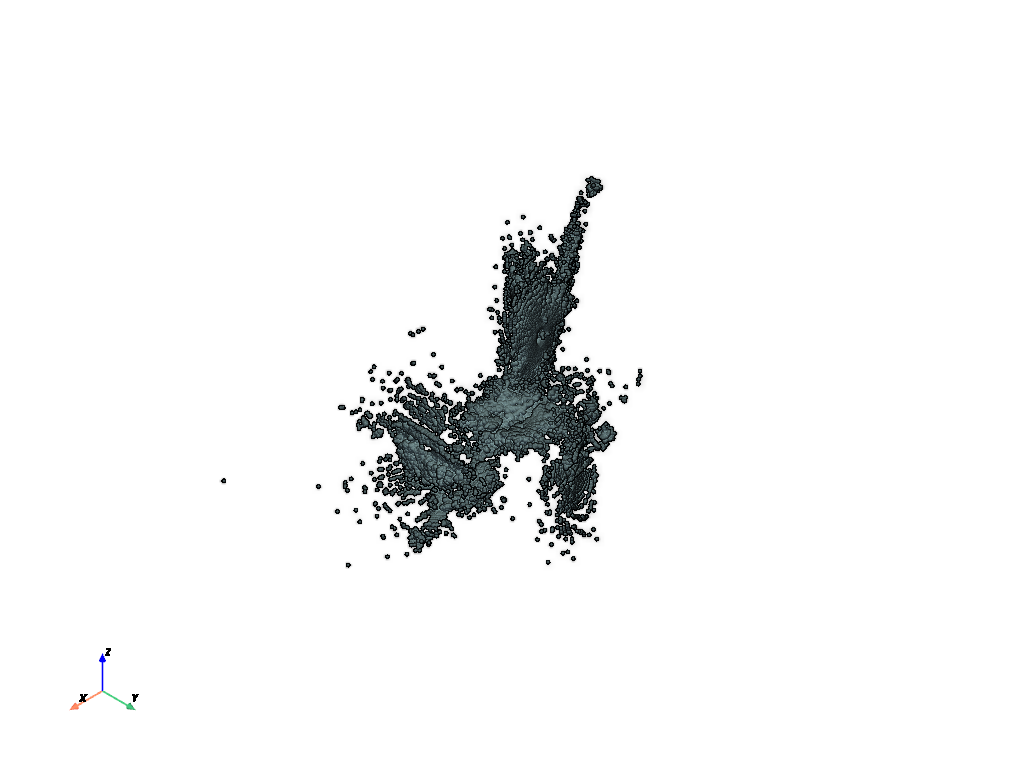

In [79]:
pv.start_xvfb()
point_cloud_pv = pv.PolyData(point_cloud * 45)
point_cloud_pv.plot(eye_dome_lighting=True, render_points_as_spheres=True, jupyter_backend='static')